## This notebook will introduce how to use the transpharmer model to generate molecules based on specific pharmacophore fingerprints and scaffolds (iterative style)

### Firstly, we can generate molecules based solely on their pharmacophore fingerprints.

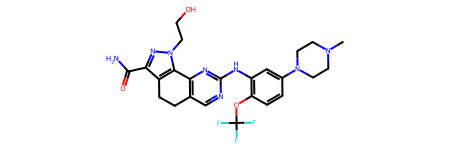

In [1]:
# import necessary
from rdkit import Chem
# look at our ligand(use 2yac as an example)
lig = Chem.MolFromSmiles('N1=CC2CCC3C(C(N)=O)=NN(CCO)C=3C=2N=C1NC1=C(OC(F)(F)F)C=CC(N2CCN(C)CC2)=C1')
# Demonstrate the template molecule
lig

In [2]:
from utils.io import load_config
# Read the configuration template of the generate task
config = load_config('configs/generate_pc.yaml')
# Displays the current configuration
config

CfgNode({'DEVICE': 'cuda:3', 'RANDOM_SEED': 2023, 'MODEL': CfgNode({'N_LAYERS': 8, 'N_HEADS': 8, 'N_EMBD': 256, 'MAX_LEN': 100, 'NUM_PROPS': 80, 'EMBD_PDROP': 0.1, 'RESID_PDROP': 0.1, 'ATTN_PDROP': 0.1, 'VOCAB_SIZE': 94}), 'GENERATE': CfgNode({'CONTEXT': 'C', 'BATCH_SIZE': 200, 'N_CPU': 1, 'VERSION': 'nc', 'TEMPERATURE': 1.0, 'TEMPLATES': ['COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OC', 'CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O', 'CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1'], 'OUTPUT': 'output/generate_pc/out.smi', 'CKPT_PATH': 'weights/guacamol_pc.pt', 'TOTAL': 1000000.0})})

In [3]:
# Specify the template molecule
config.GENERATE.TEMPLATES = ['N1=CC2CCC3C(C(N)=O)=NN(CCO)C=3C=2N=C1NC1=C(OC(F)(F)F)C=CC(N2CCN(C)CC2)=C1']
# Specify where the growth results are saved
config.GENERATE.OUTPUT = 'output/generate_pc/2yac_pharmacore.smi'
# Specifies how many molecules to generate
config.GENERATE.TOTAL = 100
# Displays the current configuration
config

CfgNode({'DEVICE': 'cuda:3', 'RANDOM_SEED': 2023, 'MODEL': CfgNode({'N_LAYERS': 8, 'N_HEADS': 8, 'N_EMBD': 256, 'MAX_LEN': 100, 'NUM_PROPS': 80, 'EMBD_PDROP': 0.1, 'RESID_PDROP': 0.1, 'ATTN_PDROP': 0.1, 'VOCAB_SIZE': 94}), 'GENERATE': CfgNode({'CONTEXT': 'C', 'BATCH_SIZE': 200, 'N_CPU': 1, 'VERSION': 'nc', 'TEMPERATURE': 1.0, 'TEMPLATES': ['N1=CC2CCC3C(C(N)=O)=NN(CCO)C=3C=2N=C1NC1=C(OC(F)(F)F)C=CC(N2CCN(C)CC2)=C1'], 'OUTPUT': 'output/generate_pc/2yac_pharmacore.smi', 'CKPT_PATH': 'weights/guacamol_pc.pt', 'TOTAL': 100})})

In [ ]:
# now, import our generator
from generate import generate

In [5]:
# generate mols
generate(config)

INFO:root:Statictic: unique:0.9523809523809523 | repeat:0.0 | invalid:0.047619047619047616 | total:105


In [6]:
# see our results
!cat output/generate_pc/2yac_pharmacore.smi | head -n 5

CN1CCC(Nc2ccc(Nc3nc4c(cn3)CCCc3c-4n(C)nc3C(N)=O)c(OC(F)(F)F)c2F)CC1
CN(C)CCNc1cccc(N2CCc3cnc(Nc4ccc(N5CCN(C(=O)C6(O)CCCO6)CC5)cc4OC(F)(F)F)nc32)c1OC(F)F
CN1CCN(C(C)(C)CNc2ccc(OC(F)(F)F)c(Nc3ncc4c(n3)-c3c(c(C(C)(O)COC)nn3C)CC4)c2)CC1
CN1CCC(Nc2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3C(O)(CO)C(F)(F)F)CC4)c(S(C)(=O)=O)c2)CC1
CNC(=O)c1cc2c(n1C)-c1c(cnc(Nc3ccc(N4CCN(C(C)(C)CO)CC4)cc3OC)n1)CC2


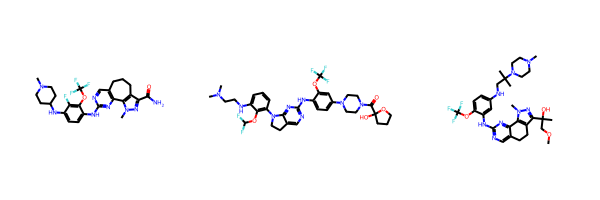

In [16]:
# take 3 from output above and view with rdkit
from rdkit.Chem import Draw
smis = ['CN1CCC(Nc2ccc(Nc3nc4c(cn3)CCCc3c-4n(C)nc3C(N)=O)c(OC(F)(F)F)c2F)CC1', \
        'CN(C)CCNc1cccc(N2CCc3cnc(Nc4ccc(N5CCN(C(=O)C6(O)CCCO6)CC5)cc4OC(F)(F)F)nc32)c1OC(F)F', \
        'CN1CCN(C(C)(C)CNc2ccc(OC(F)(F)F)c(Nc3ncc4c(n3)-c3c(c(C(C)(O)COC)nn3C)CC4)c2)CC1']
mols = []
for smi in smis:
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)
img = Draw.MolsToGridImage(mols)
img

### Secondly, we can generate molecules with pharmacophore fingerprints and specific scaffold.

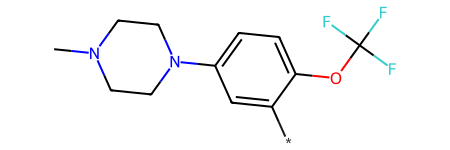

In [8]:
# we can slice part of our whole mol as scaffold(cut point is marked as *)
scaffold = Chem.MolFromSmiles('*C1C=C(N2CCN(C)CC2)C=CC=1OC(F)(F)F')
scaffold

In [9]:
# now, we randomize the scaffold smiles to get needed(* is placed at last in smiles string) contexts for out model input
from utils.mol import enumerate_fixed_scaf_smiles
# Traversing the molecular fragment to get the fragments to be used as scaffolds
scaffolds = enumerate_fixed_scaf_smiles('*C1C=C(N2CCN(C)CC2)C=CC=1OC(F)(F)F')
scaffolds

{'C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1',
 'FC(F)(F)Oc1ccc(N2CCN(C)CC2)cc1',
 'O(C(F)(F)F)c1ccc(N2CCN(C)CC2)cc1',
 'c1(OC(F)(F)F)ccc(N2CCN(C)CC2)cc1',
 'c1c(N2CCN(C)CC2)ccc(OC(F)(F)F)c1'}

In [10]:
# load a config file as template
from utils.io import load_config
config = load_config('configs/generate_pc.yaml')
config

CfgNode({'DEVICE': 'cuda:3', 'RANDOM_SEED': 2023, 'MODEL': CfgNode({'N_LAYERS': 8, 'N_HEADS': 8, 'N_EMBD': 256, 'MAX_LEN': 100, 'NUM_PROPS': 80, 'EMBD_PDROP': 0.1, 'RESID_PDROP': 0.1, 'ATTN_PDROP': 0.1, 'VOCAB_SIZE': 94}), 'GENERATE': CfgNode({'CONTEXT': 'C', 'BATCH_SIZE': 200, 'N_CPU': 1, 'VERSION': 'nc', 'TEMPERATURE': 1.0, 'TEMPLATES': ['COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OC', 'CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O', 'CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1'], 'OUTPUT': 'output/generate_pc/out.smi', 'CKPT_PATH': 'weights/guacamol_pc.pt', 'TOTAL': 1000000.0})})

In [11]:
# Specify the template molecule
config.GENERATE.TEMPLATES = ['N1=CC2CCC3C(C(N)=O)=NN(CCO)C=3C=2N=C1NC1=C(OC(F)(F)F)C=CC(N2CCN(C)CC2)=C1']
# take a output from above output as scaffold and set config
config.GENERATE.CONTEXT = 'C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1'
# Specify the path where the growth results to be saved
config.GENERATE.OUTPUT = 'output/generate_pc/2yac_pharmacore_scaffold.smi'
# Specifies how many molecules to generate
config.GENERATE.TOTAL = 100
# Displays the current configuration
config

CfgNode({'DEVICE': 'cuda:3', 'RANDOM_SEED': 2023, 'MODEL': CfgNode({'N_LAYERS': 8, 'N_HEADS': 8, 'N_EMBD': 256, 'MAX_LEN': 100, 'NUM_PROPS': 80, 'EMBD_PDROP': 0.1, 'RESID_PDROP': 0.1, 'ATTN_PDROP': 0.1, 'VOCAB_SIZE': 94}), 'GENERATE': CfgNode({'CONTEXT': 'C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1', 'BATCH_SIZE': 200, 'N_CPU': 1, 'VERSION': 'nc', 'TEMPERATURE': 1.0, 'TEMPLATES': ['N1=CC2CCC3C(C(N)=O)=NN(CCO)C=3C=2N=C1NC1=C(OC(F)(F)F)C=CC(N2CCN(C)CC2)=C1'], 'OUTPUT': 'output/generate_pc/2yac_pharmacore_scaffold.smi', 'CKPT_PATH': 'weights/guacamol_pc.pt', 'TOTAL': 100})})

In [12]:
# Generate molecules
generate(config)

INFO:root:Statictic: unique:0.7194244604316546 | repeat:0.2446043165467626 | invalid:0.03597122302158273 | total:139


In [13]:
!cat output/generate_pc/2yac_pharmacore_scaffold.smi | head -n 5

C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1nc2c(cn1)CCc1c-2n(C)c(C(N)=O)c1C(CO)(OC)O
C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1nnc2c(n1)-c1c(c(NCCOC(=O)N(C)C)ccc1)CC2
C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1ncc2c(n1)-c1c(nn(C)c1C(N)=O)CC2OC(=O)N(C)C
C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1nc2c(cn1)CCc1c-2n(C)nc1C(=O)NCCO
C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1ncc2ccc(C(=NC3(O)C(=O)N(C)CCC3)O)cc2n1


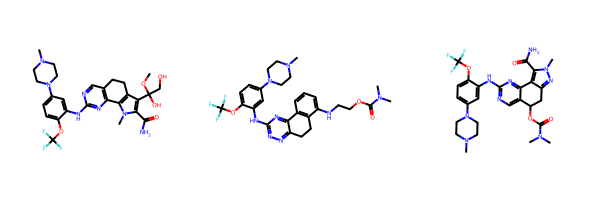

In [15]:
# take 3 from output above and view with rdkit, now look for difference
from rdkit.Chem import Draw
smis = ['C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1nc2c(cn1)CCc1c-2n(C)c(C(N)=O)c1C(CO)(OC)O', \
        'C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1nnc2c(n1)-c1c(c(NCCOC(=O)N(C)C)ccc1)CC2', \
        'C(F)(F)(F)Oc1ccc(N2CCN(C)CC2)cc1Nc1ncc2c(n1)-c1c(nn(C)c1C(N)=O)CC2OC(=O)N(C)C']
mols = []
for smi in smis:
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)
img = Draw.MolsToGridImage(mols)
img